In [103]:
# Evolutionary algorithm

import networkx as nx
import numpy as np
from pyswarm import pso
import matplotlib.pyplot as plt
import math
from random import randint, uniform
import copy


In [9]:
def generateNewValue(lim1, lim2):
    return uniform(lim1, lim2)


def binToInt(x):
    val = 0
    # x.reverse()
    for bit in x:
        val = val * 2 + bit
    return val


In [10]:
paths = ["./data/real/" + name + "/" + name + ".gml" for name in ["dolphins", "football", "karate", "krebs"]]

In [90]:
class Chromosome:
    def __init__(self, network, problParam=None):
        self.__problParam = problParam
        self.__repres = self.init_repres(network)
        self.__fitness = 0.0
    def init_repres(self, network):
        
        mat = network['mat']

        l = [-1 for _ in range(0, len(mat))]

        pos = 0
        done = False

        while not done:
            done = True
            com = randint(self.__problParam['min'], self.__problParam['max'])
            l[pos] = com
            for i in range(0, len(mat)):
                if mat[pos][i] == 1:
                    l[i] = com

            for j in range(0, len(mat)):
                if l[j] == -1:
                    pos = j
                    done = False
                    break

        return l
    @property
    def repres(self):
        return self.__repres

    @property
    def fitness(self):
        return self.__fitness

    @repres.setter
    def repres(self, l=[]):
        self.__repres = l

    @fitness.setter
    def fitness(self, fit=0.0):
        self.__fitness = fit

    def crossover(self, c, network):
        
        r = randint(0, len(self.__repres) - 1)

        child = []

        for i in range(0, len(self.__repres)):

            if self.__repres[i] == self.__repres[r]:

                child.append(self.__repres[i])

            else:

                child.append(c.__repres[i])

        c1 = Chromosome(network, self.__problParam)

        c1.__repres = child

        return c1

    def mutation(self, pm):
        """
        Mutation of a chromosome
        :param pm: probability of mutation
        """
        pos = randint(0, len(self.__repres) - 1)
        randfloat = uniform(0, 1)
        if randfloat <= pm:
            self.__repres[pos] = generateNewValue(self.__problParam['min'], self.__problParam['max'])

    def __str__(self):
        return "\nChromo: " + str(self.__repres) + " has fit: " + str(self.__fitness)

    def __repr__(self):
        return self.__str__()

    def __eq__(self, c):
        return self.__repres == c.__repres and self.__fitness == c.__fitness


In [12]:
class GeneticAlgorithm:
    def __init__(self, network, param=None, problParam=None):
       
        self.__param = param
        self.__problParam = problParam
        self.__population = []
        self.__network = network

    @property
    def population(self):
        """
        Get method for population
        :return: population
        """
        return self.__population

    def initialisation(self):
        """
        intialize population
        """
        for _ in range(0, self.__param["popSize"]):
            c = Chromosome(self.__network, self.__problParam)
            self.__population.append(c)

    def evaluation(self):
        """
        Population evaluation
        """
        for c in self.__population:
            c.fitness = self.__problParam["function"](c.repres, self.__network)

    def worstChromosome(self):
        """
        Worst fitness
        :return: worst fitness chromosome
        """
        worst = self.__population[0]
        for c in self.__population:
            if c.fitness < worst.fitness:
                worst = c
        return worst

    def bestChromosome(self):
        """
        Best fitness
        :return: best fitness chromosome
        """
        best = self.__population[0]
        for c in self.__population:
            if c.fitness > best.fitness:
                best = c
        return best

    def selection(self):
        """
        Returns the better chromosome
        :return: better chromosome
        """
        pos1 = randint(0, self.__param["popSize"] - 1)
        pos2 = randint(0, self.__param["popSize"] - 1)
        if self.__population[pos1].fitness > self.__population[pos2].fitness:
            return pos1
        else:
            return pos2

    def oneGeneration(self):
        """
        Generate chromosomes every new generation
        """
        newPop = []
        for _ in range(self.__param["popSize"]):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2, self.__network)
            off.mutation(self.__param["pm"])
            newPop.append(off)
        self.__population = newPop
        self.evaluation()

    def oneGenerationElitism(self):
        """
        Remain only the best chromosomes - Elitism
        """
        newPop = [self.bestChromosome()]
        for _ in range(self.__param["popSize"] - 1):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2, self.__network)
            off.mutation(self.__param["pm"])
            newPop.append(off)
        self.__population = newPop
        self.evaluation()

    def oneGenerationSteadyState(self):
        """
        Steady State
        """
        for _ in range(self.__param["popSize"]):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2, self.__network)
            off.mutation(self.__param["pm"])
            off.fitness = self.__problParam["function"](off.repres, self.__network)
            worst = self.worstChromosome()
            if off.fitness < worst.fitness:
                worst = off

In [108]:



def draw_graph(G, communities):

    node_groups = []
    for item in range(max(communities)+1):
        node_groups.append([])
    for node in range(len(communities)):
        node_groups[communities[node]].append(node)
 
    # print(node_groups)

    color_map = []
    nrcommunities = len(node_groups)
    colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'brown', 'black', 'grey']
    for node in range(len(G.nodes())):
        for node_group in range(nrcommunities):
            if node in node_groups[node_group]:
                color_map.append(colors[node_group])
    plt.figure(figsize=(20,20))
    nx.draw_networkx(G,pos= nx.spring_layout(G), node_color=color_map, with_labels=False)
    # nx.draw(G, pos=nx.spring_layout(G), node_color=color_map, with_labels=False, node_size=500)
    # nx.draw_networkx_nodes(G, pos=nx.spring_layout(G), node_color=color_map)
    # nx.draw_networkx_edges(G, pos=nx.spring_layout(G), alpha=0.5, edge_color = "black")
    plt.show()

def modularity(communities, network):
    
    noNodes = network['noNodes']
    mat = network['mat']
    degrees = network['degrees']
    noEdges = network['noEdges']
    comm_size = network['communitySize']
    M = 2 * noEdges
    Q = 0.0
    for i in range(0, noNodes):
        for j in range(0, noNodes):
            if (communities[i] == communities[j]):
                Q += (mat[i][j] - degrees[i] * degrees[j] / M)

    #communities that don't have the number of communities equal to comm_size get a penalty
    #the fitness will be modified
    # penalty = 0

    # if len(set(communities)) != comm_size:
    #         penalty = comm_size - len(set(communities))

    return Q / M #- penalty

def fitness(communities, network):
    # define the fitness function as the degree to which nodes come together in communities

    noNodes = network['noNodes']
    mat = network['mat']
    degrees = network['degrees']
    noEdges = network['noEdges']
    comm_size = network['communitySize']
    M = 2 * noEdges
    Q = 0.0
    # girvan newman fitness function
    for i in range(len(communities)):
        # number of edges between nodes in the same community
        edgesC = 0
        edgesPartial = 0
        for nodeI in range(len(communities)):
            for nodeJ in range(len(communities)):
                if(nodeI != nodeJ and communities[nodeI] == communities[nodeJ]):
                    edgesC += mat[nodeI][nodeJ]
                if nodeJ != nodeI:
                    edgesPartial += mat[nodeI][nodeJ]
        Q += edgesC / (2 * M) - (edgesPartial / (2 * M)) ** 2
    return Q
        
def fitness2(community, network):
    # score defined by relative amount of edges between same-community nodes vs different-community nodes
    mat = network['mat']
    multime = set(copy.deepcopy(community))
    sum = 0.0
    # go through community
    for c in multime:
        score = 0.0
        for i in range(len(community)):
            if community[i] == c:
                scoreIn = 0.0
                scoreOut = 0.0
                for j in range(len(community)):
                    if mat[i][j] > 0.0:
                        if community[j] == c:
                            scoreIn += 1.0 # i and j are in the same community
                        else:
                            scoreOut += 1.0 # i and j are in different communities
                score += scoreIn / (scoreIn + scoreOut) # add the result in score
        sum += score
    return sum


In [14]:
def getDegrees(G):
    return [d for n, d in G.degree()]

In [111]:
def do_comm_detection(path, numComms, gens = 50):
    G = nx.read_gml(path)
    
    network = {'noNodes': len(G.nodes()), 'mat': nx.to_numpy_array(G), 'noEdges': len(nx.to_edgelist(G)),
            'degrees': getDegrees(G)}
    popSize = network['noNodes']
    noGen = gens
    network['communitySize'] = numComms
    # xref = [[utils.generateNewValue(0, numComms - 1) for _ in range(noDim)] for _ in range(0, 1000)]
    # xref.sort()
    # yref = [fcEval(xi) for xi in xref]

    param = {'popSize': popSize, 'noGen': noGen, 'pm': 0.5, 'pc': 0.5}

    problParam = {'min': 0, 'max': numComms - 1, 'function': modularity, 'noDim': len(network)}

    allBestFitnesses = []
    allAvgFitnesses = []
    generations = []

    ga = GeneticAlgorithm(network, param, problParam)
    ga.initialisation()
    ga.evaluation()

    bestChrom = None
    fitnessValues = []
    for g in range(param['noGen']):
        #plotting preparation
        allPotentialSolutionsX = [c.repres for c in ga.population]
        allPotentialSolutionsFitness = [c.fitness for c in ga.population]

        bestSolX = ga.bestChromosome().repres
        bestSolFitness = ga.bestChromosome().fitness

        allBestFitnesses.append(bestSolFitness)

        allAvgFitnesses.append(sum(allPotentialSolutionsFitness) / len(allPotentialSolutionsFitness))
        generations.append(g)
        # plotAFunction(xref, yref, allPotentialSolutionsX, allPotentialSolutionsY, bestSolX, [bestSolY], 'generation: ' + str(g))

        #logic alg
        ga.oneGeneration()
        # ga.oneGenerationElitism()
        # ga.oneGenerationSteadyState()
        
        bestChrom = ga.bestChromosome()
        fitnessValues.append(bestChrom.fitness)
        # print('Best solution in generation ' + str(g) + ' is: x = ' + str(bestChrom.repres) + ' f(x) = ' + str(bestChrom.fitness))
    bestChrom.repres = [int(x) for x in bestChrom.repres]
    fitnessScore = fitness(bestChrom.repres, network)
    fitnessScore2 = fitness2(bestChrom.repres, network)
    print(fitnessScore)
    print(fitnessScore2)
    draw_graph(G, bestChrom.repres)
    plt.plot(fitnessValues)
    return bestChrom
    




10.82075471698112
52.58041125541125


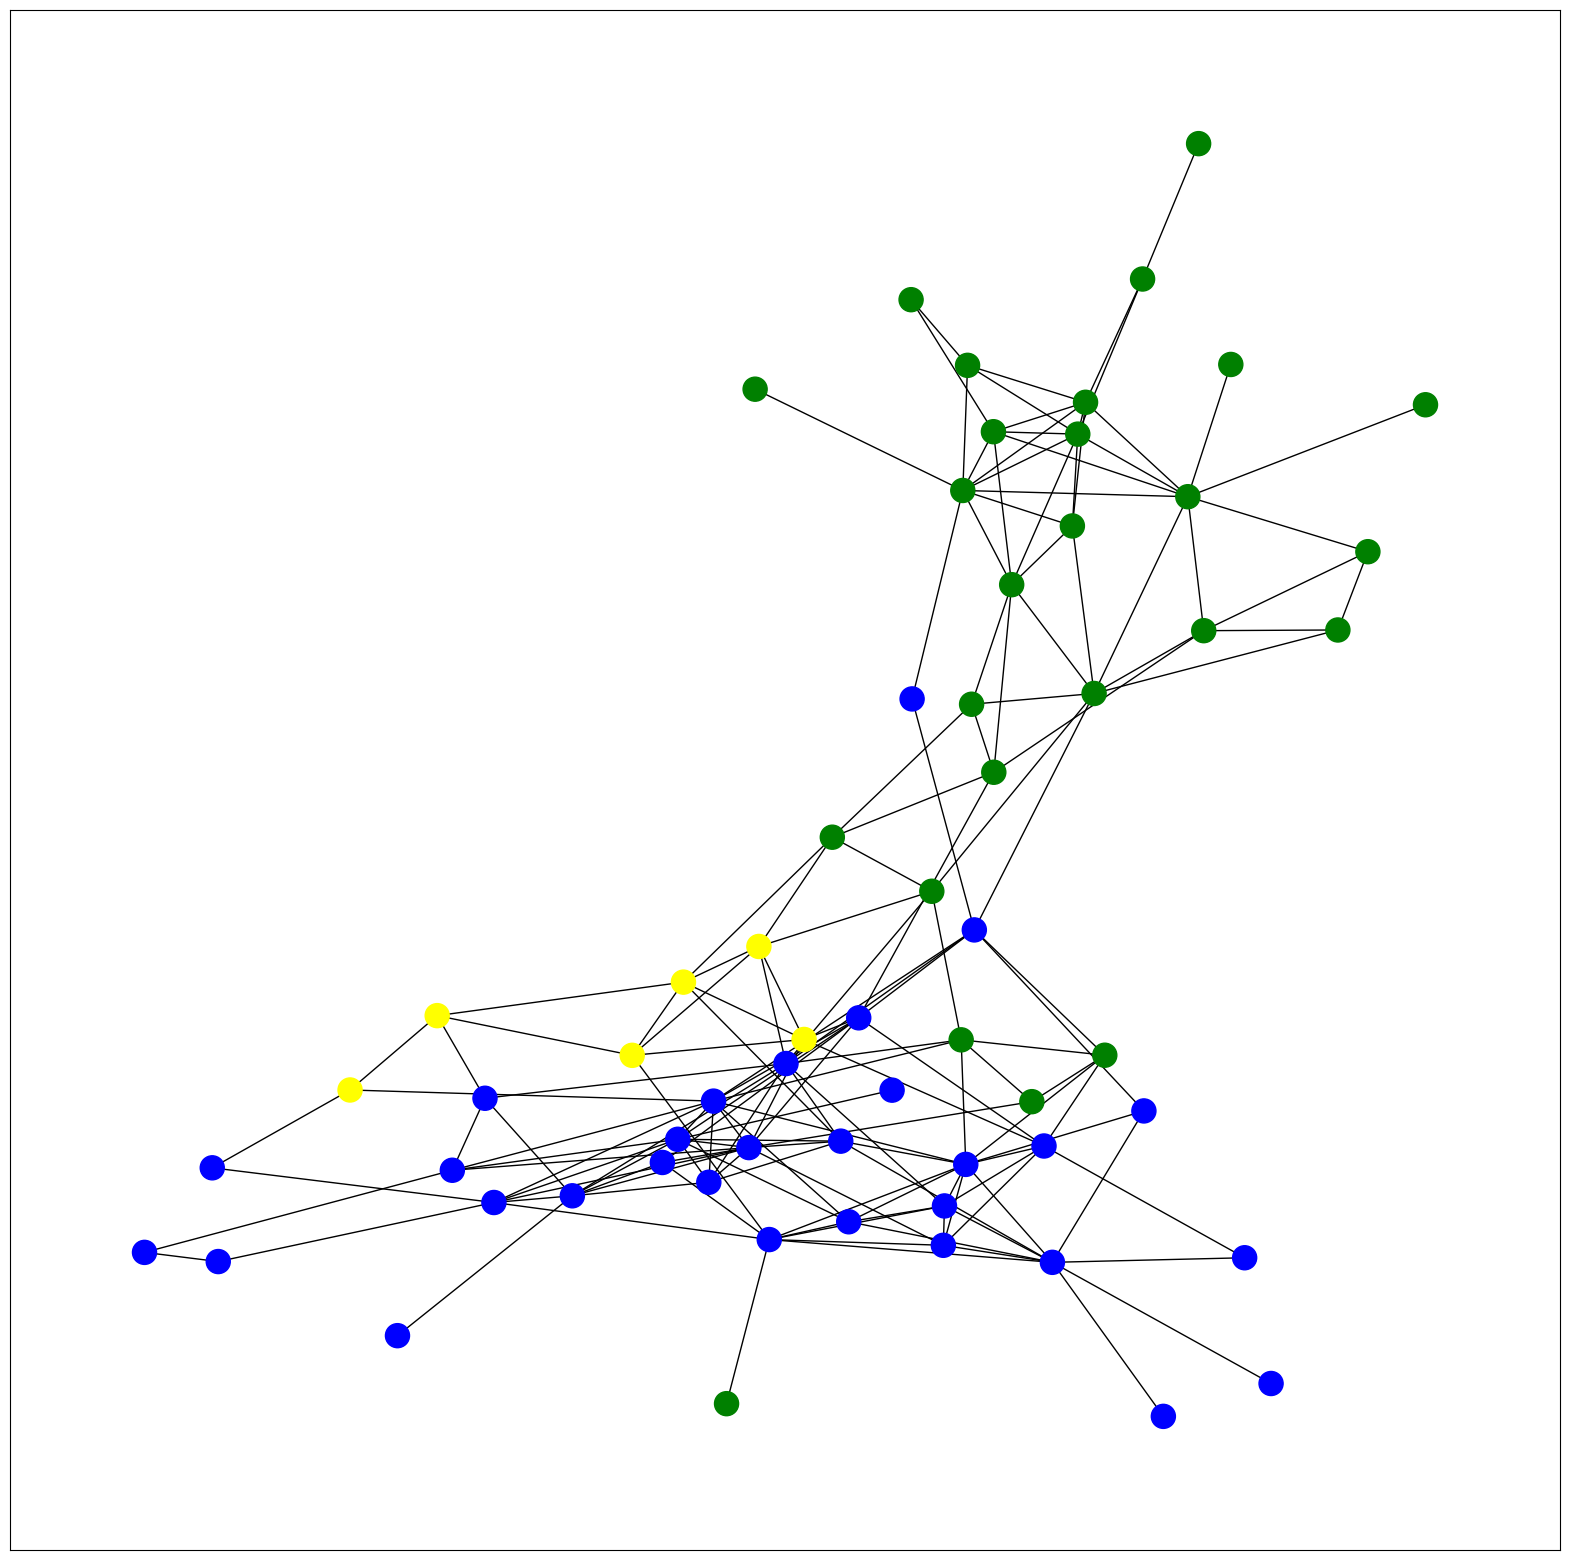

13.554241435562831
84.66681096681094


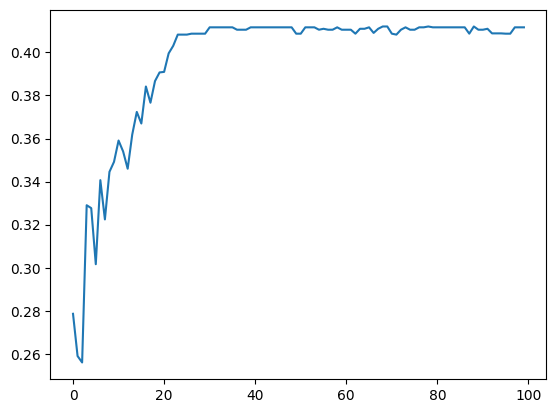

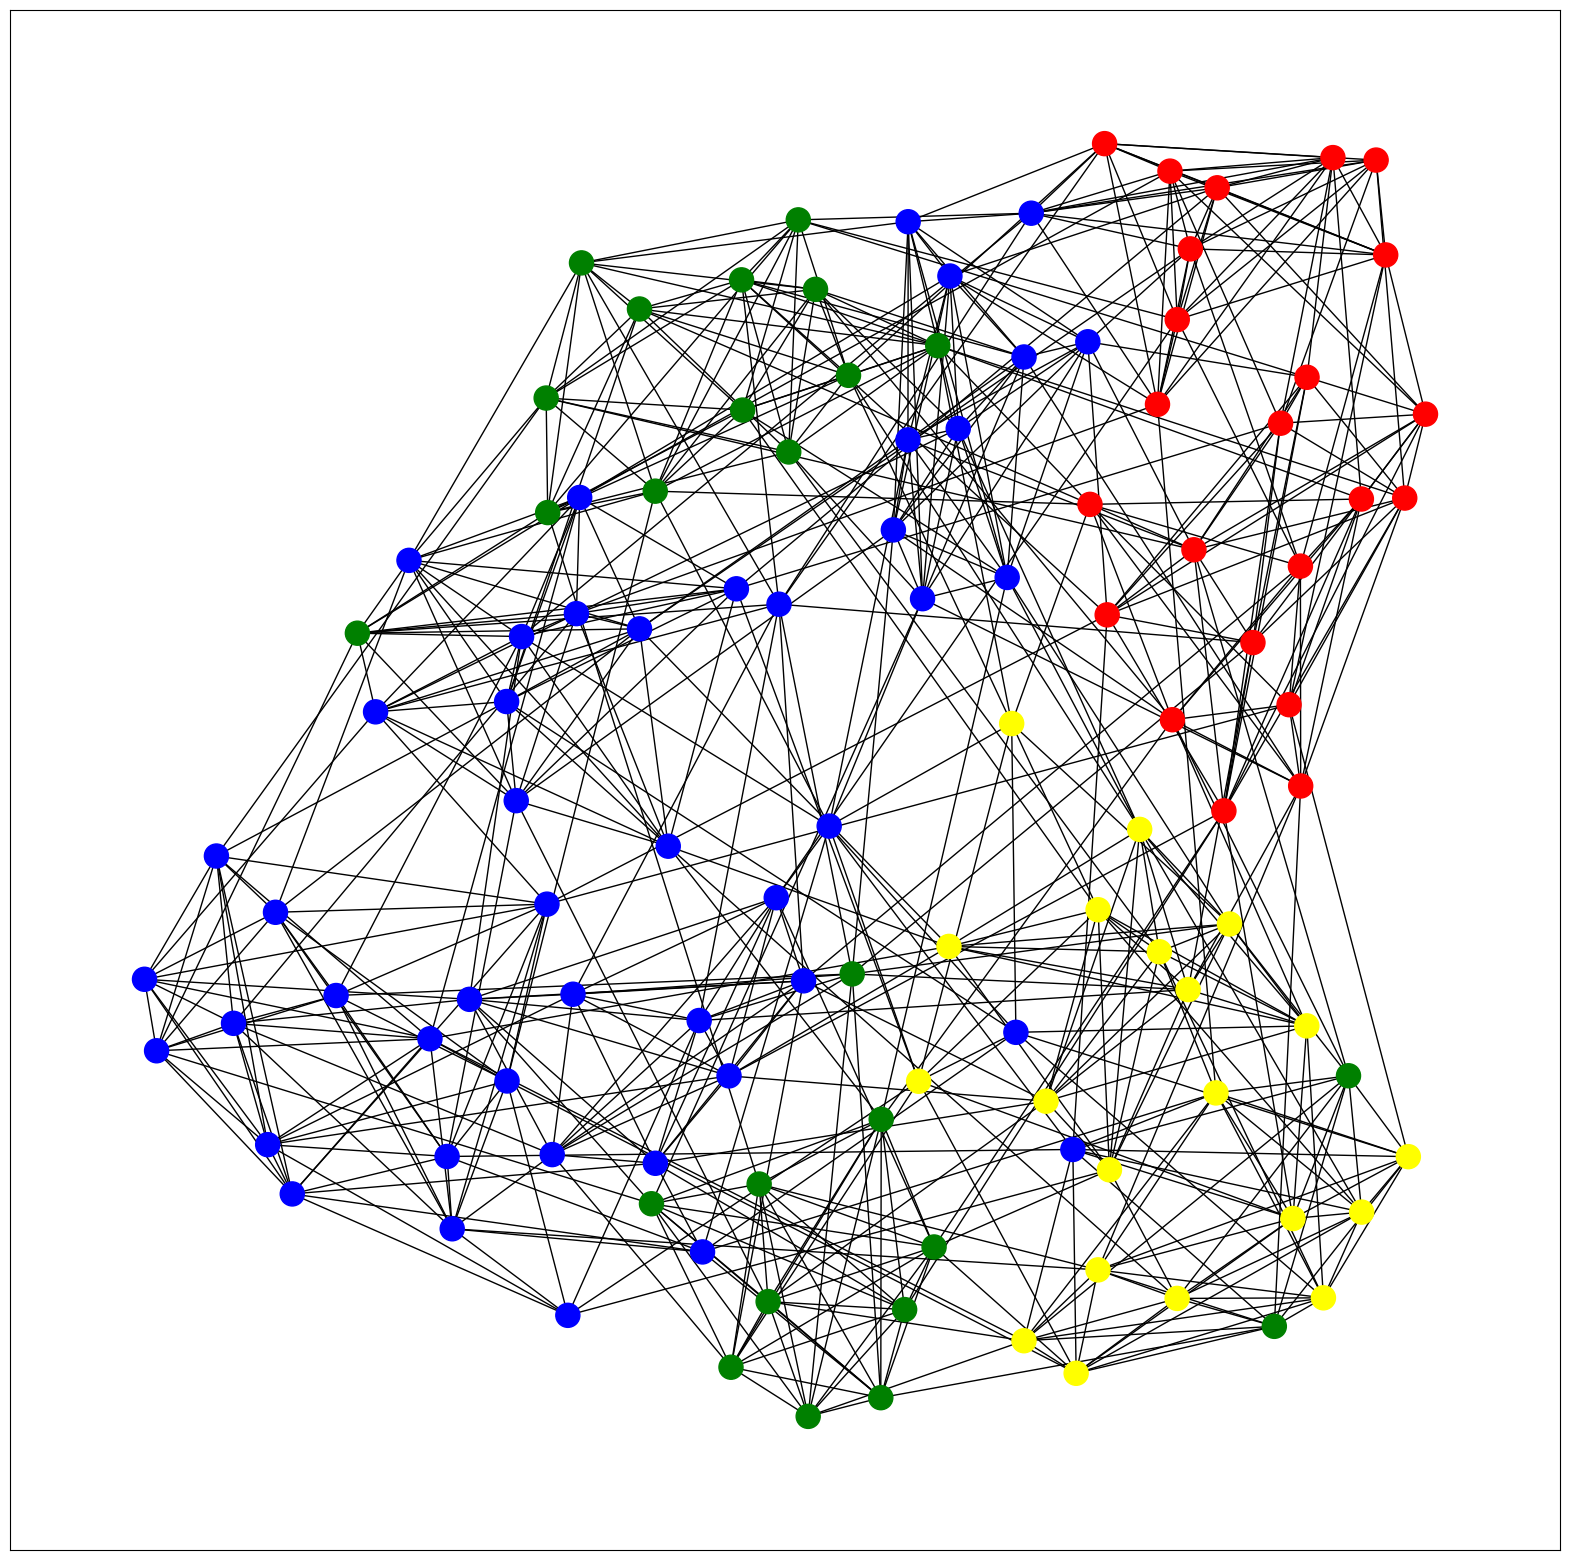

2.179487179487179
23.290522875816993


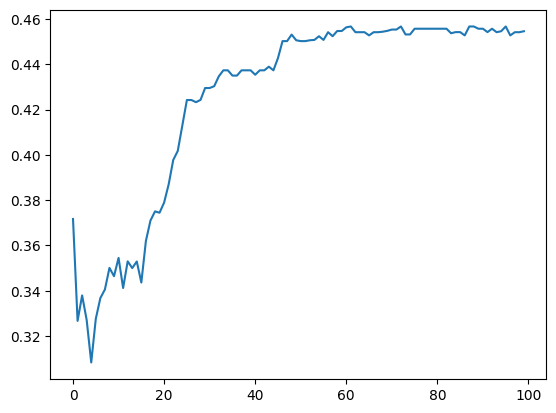

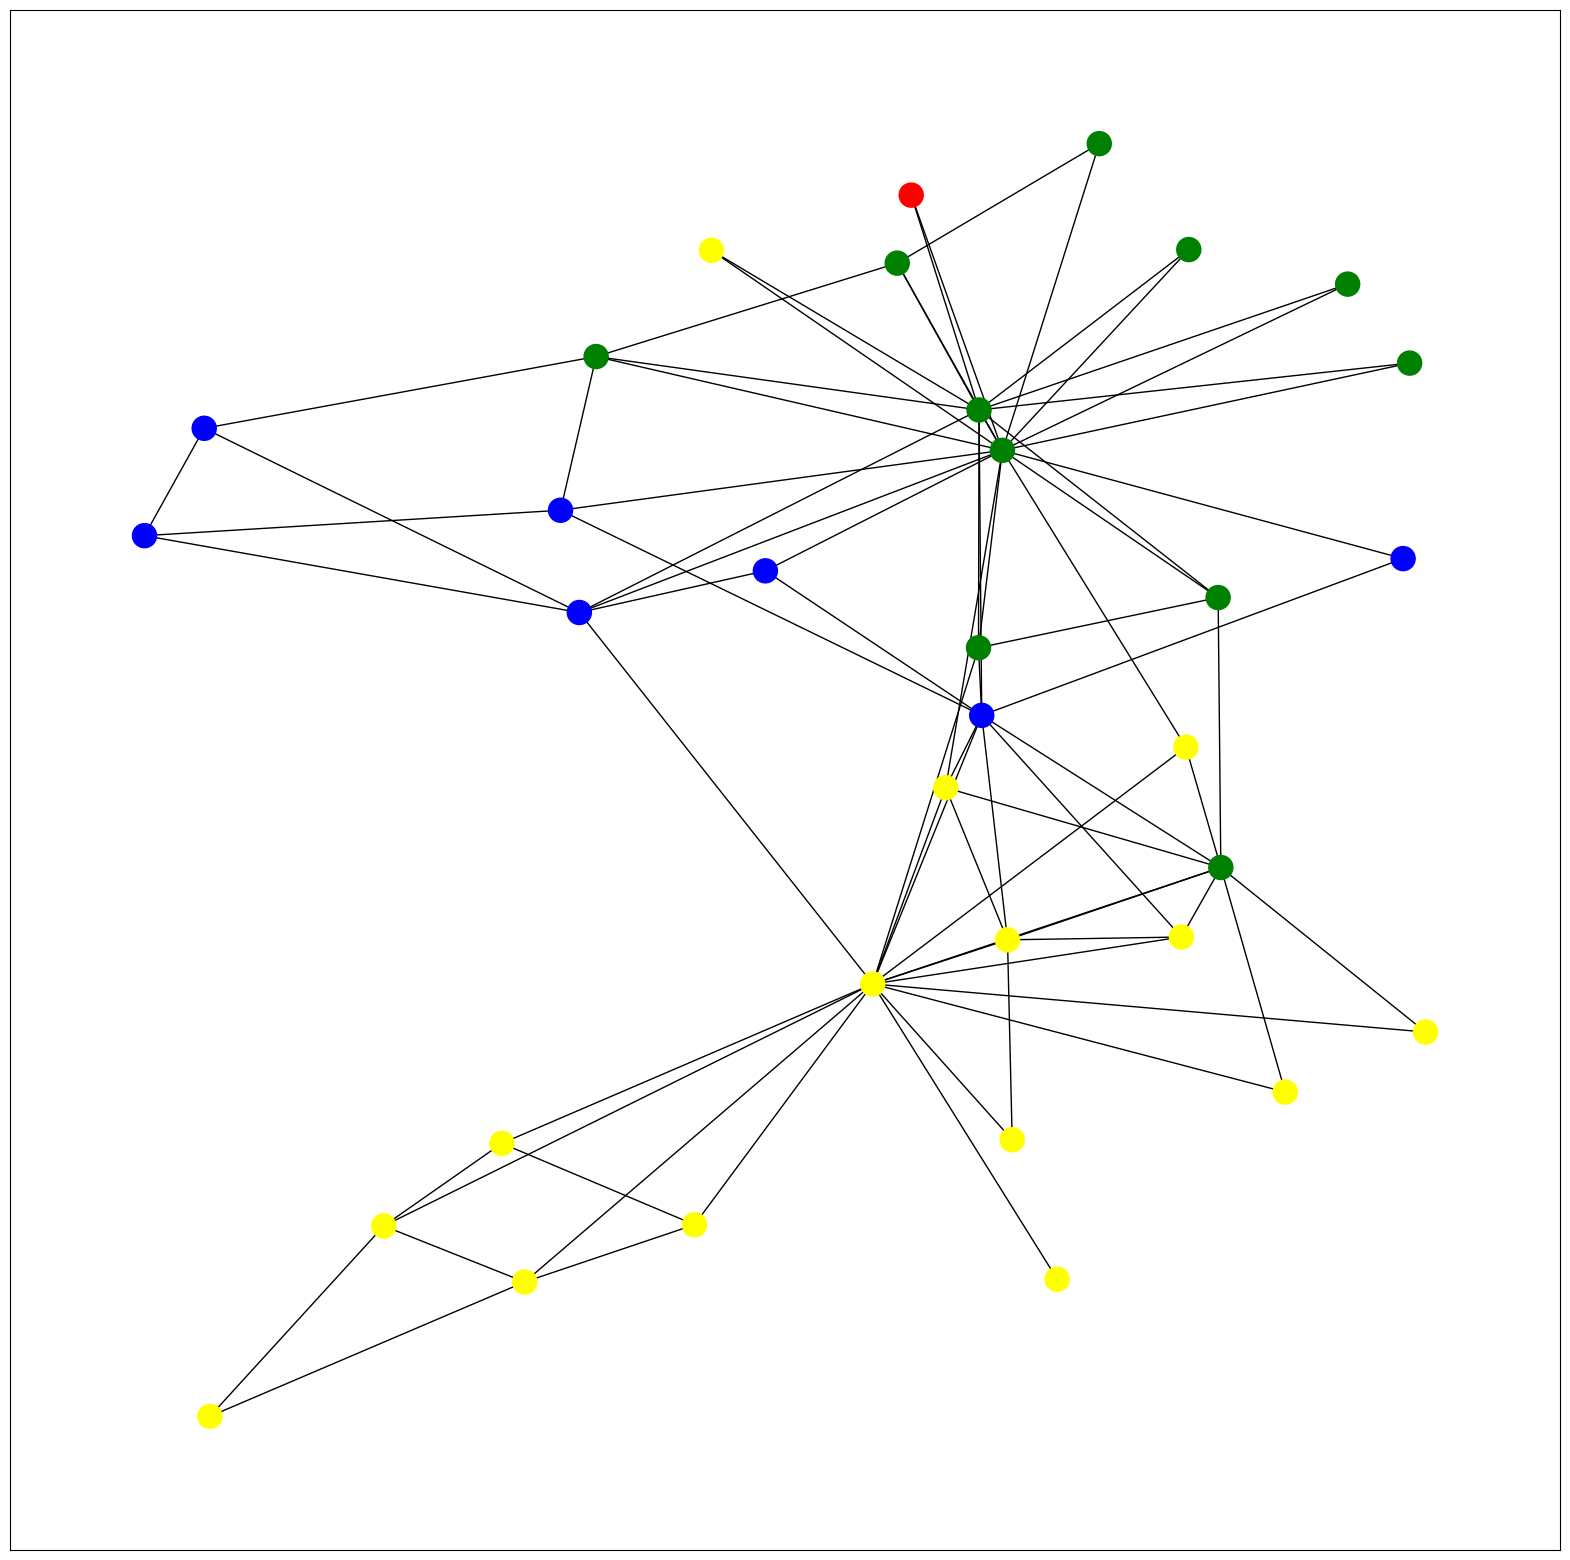

21.964285714285698
94.40879743444961


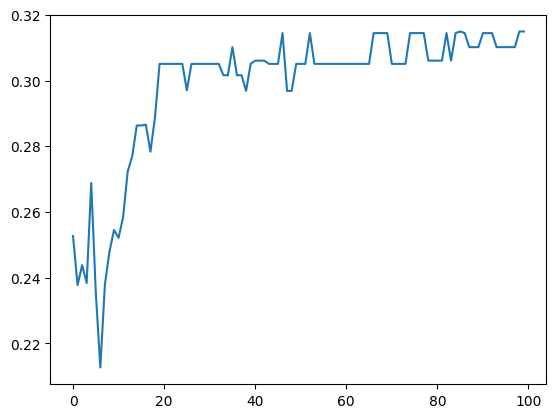

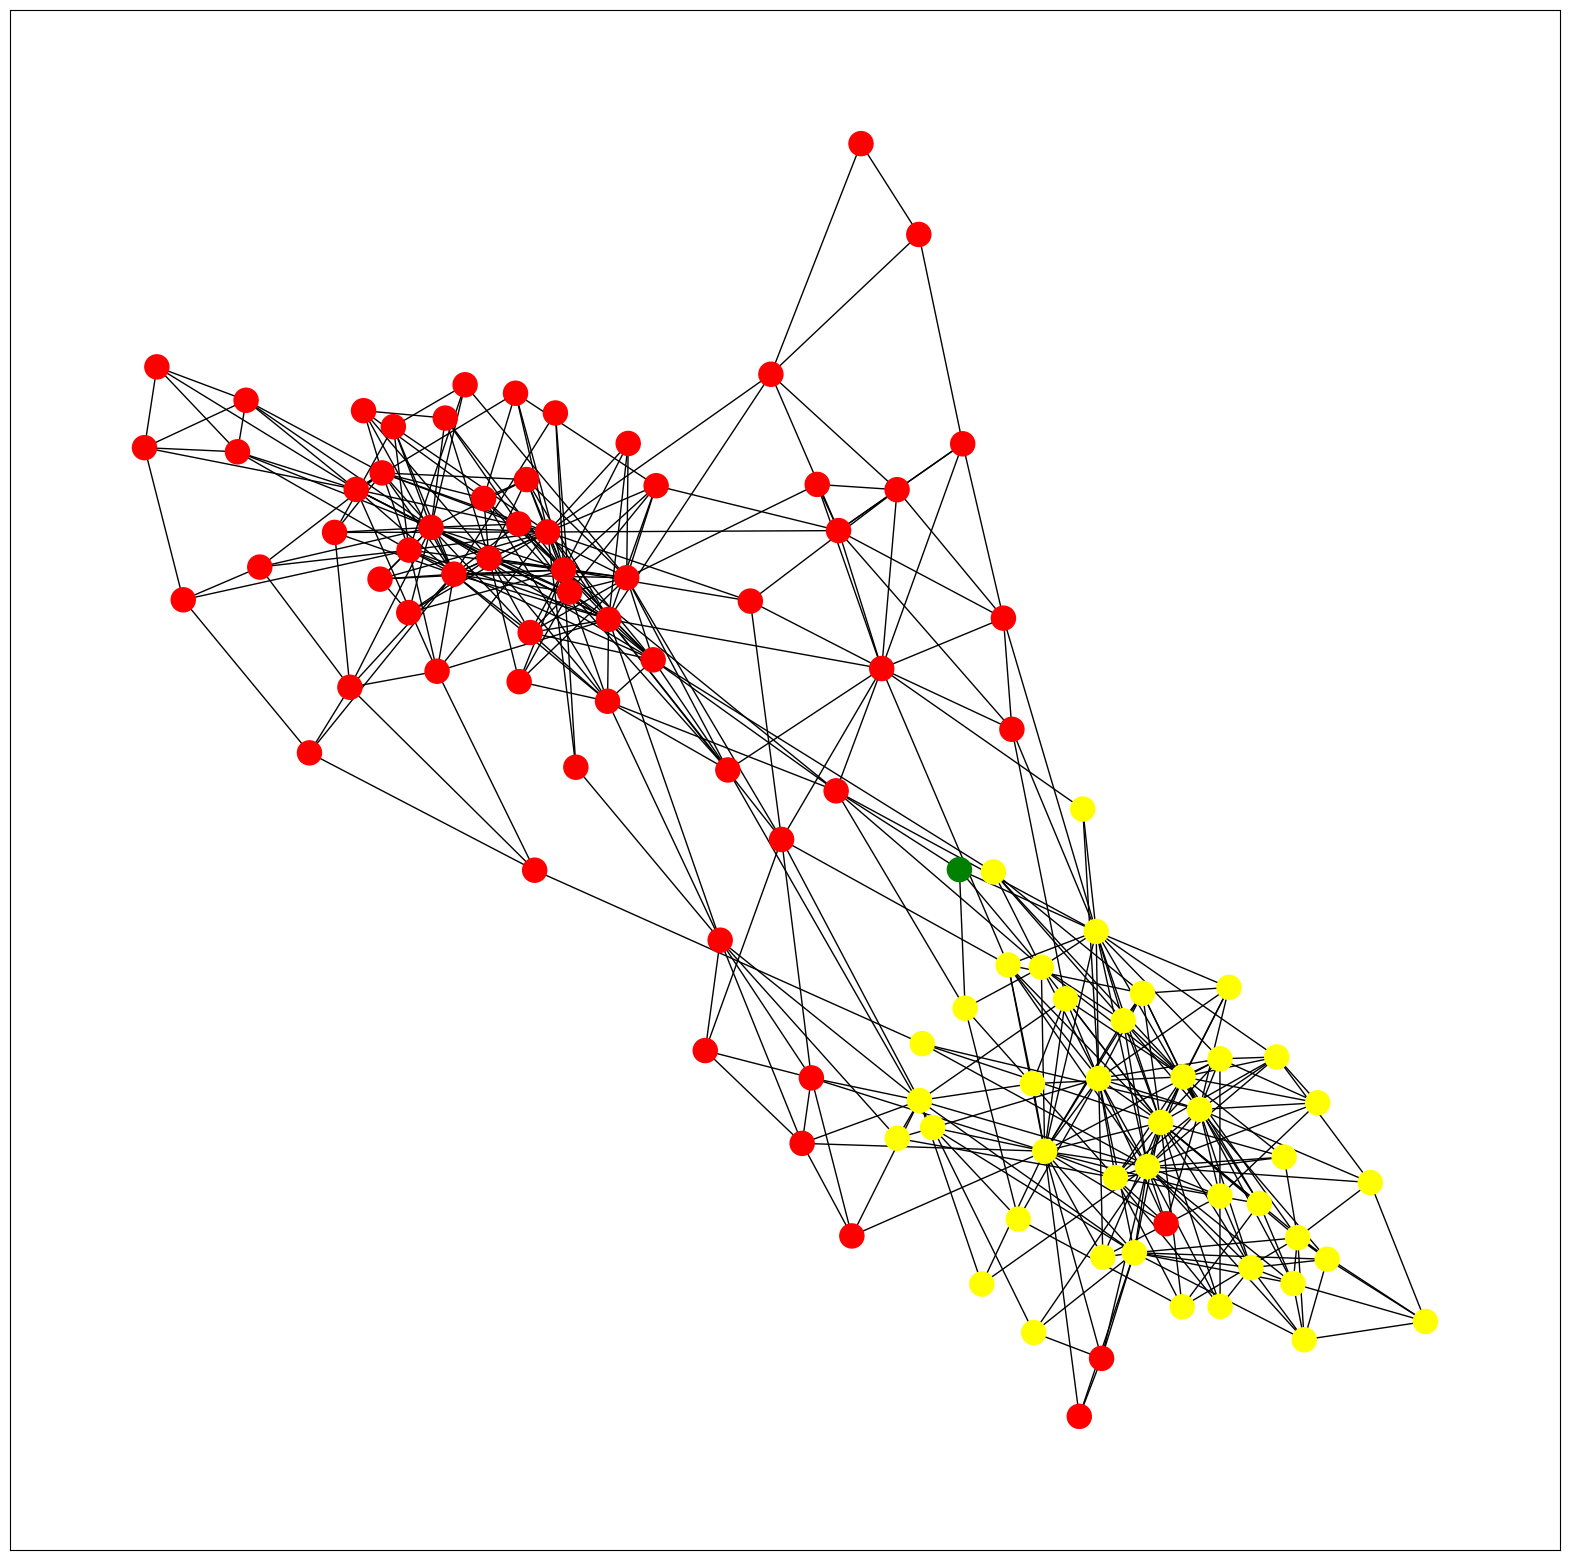

0.4116332423559186
0.45459178378204385
0.3149243918474684
0.4148091587353261


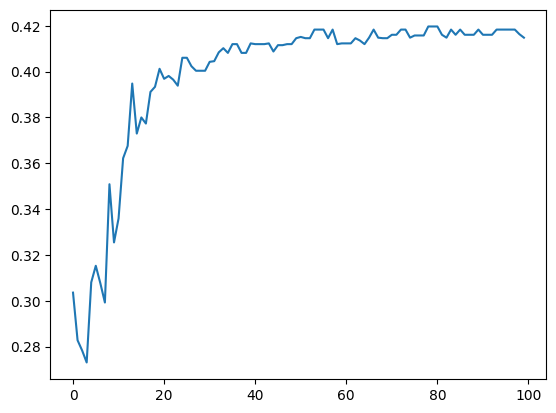

In [113]:
paths = ["./data/real/" + name + "/" + name + ".gml" for name in ["dolphins", "football", "karate", "krebs"]]
results = []
for path in paths:
    results.append(do_comm_detection(path, 5, 100))

for result in results:
    print(result.fitness)

-0.21428571428571436
2.6666666666666665


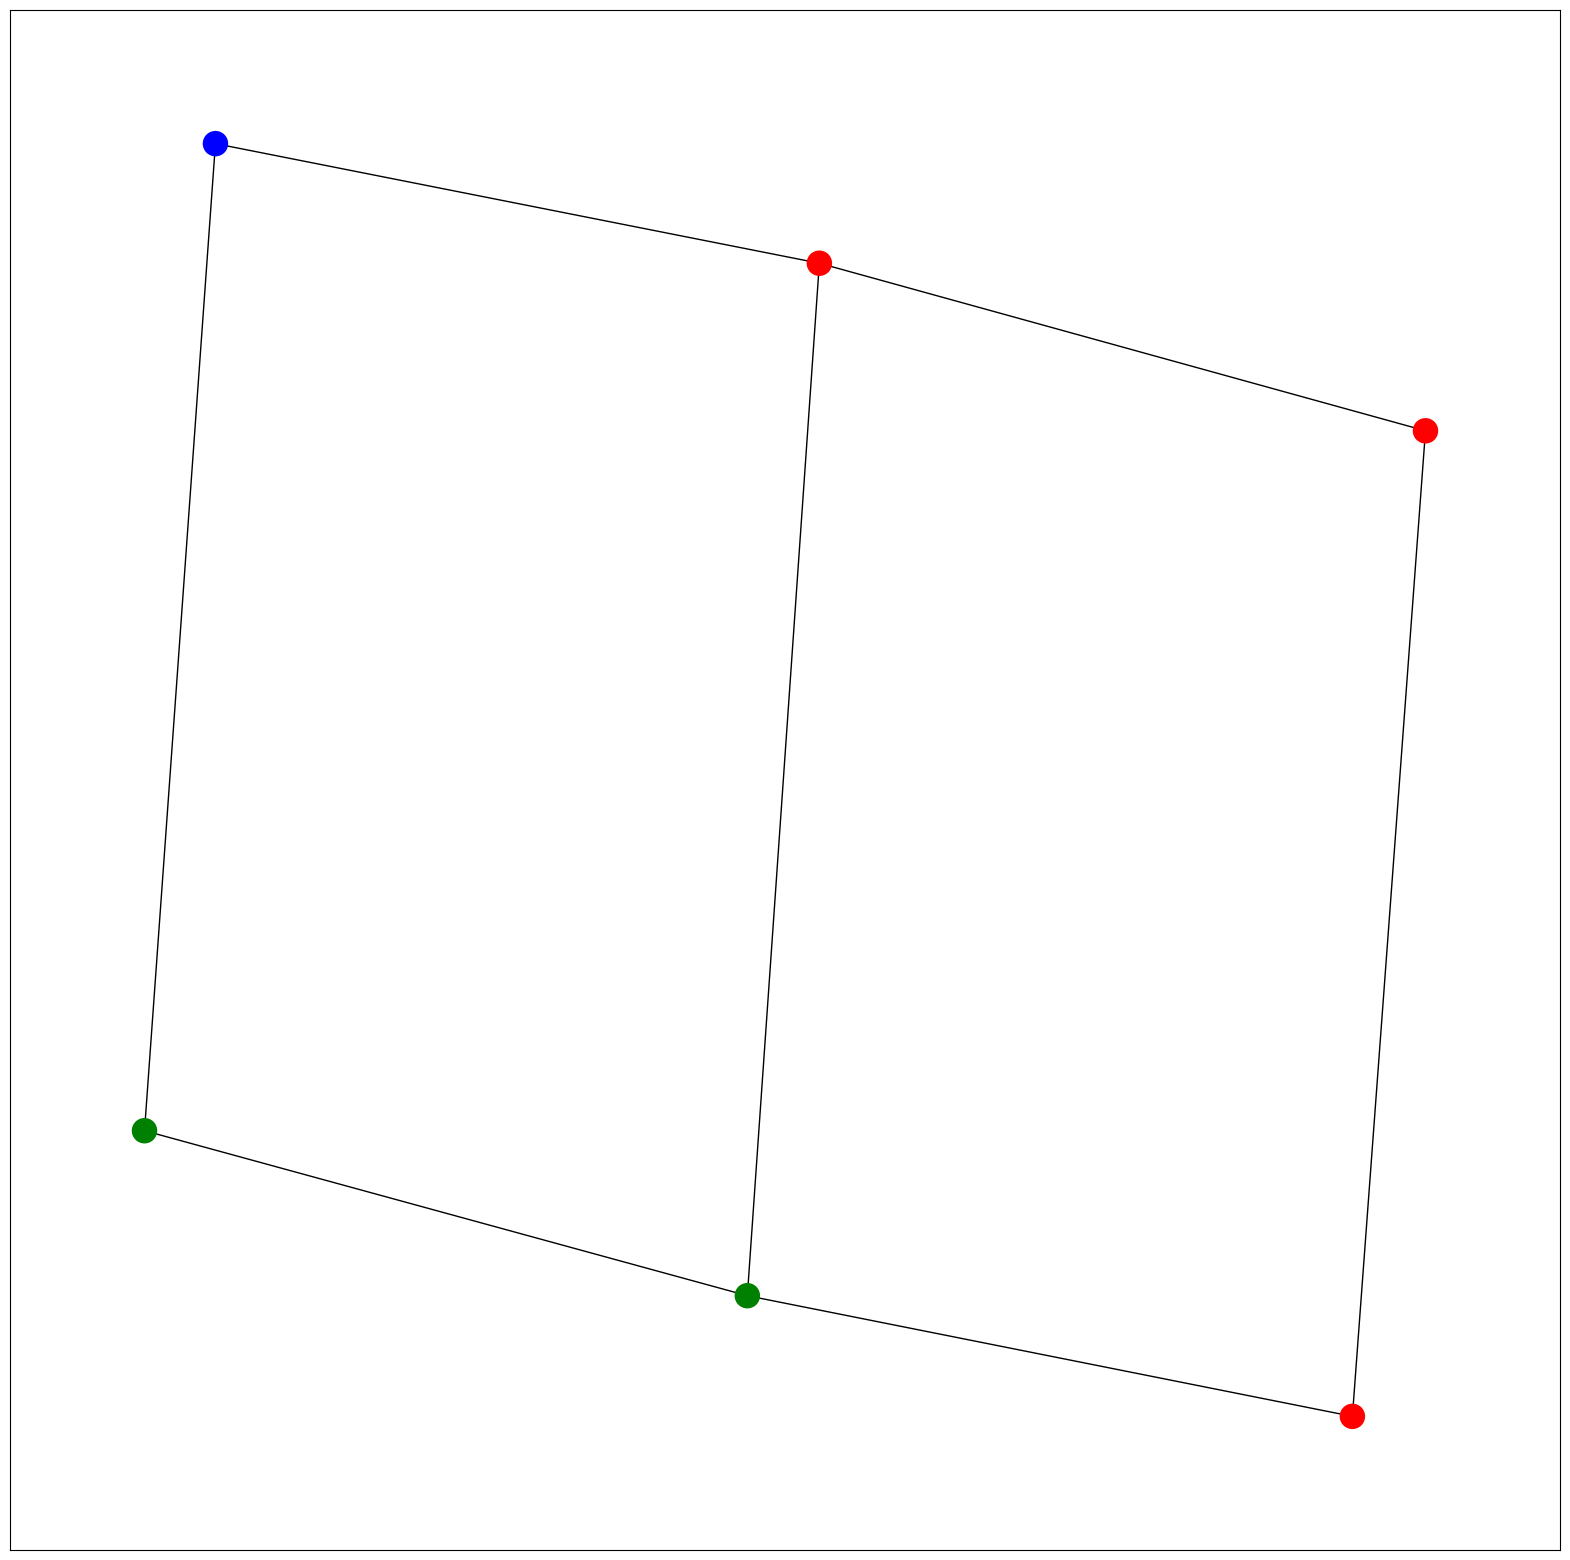

2.5
15.666666666666668


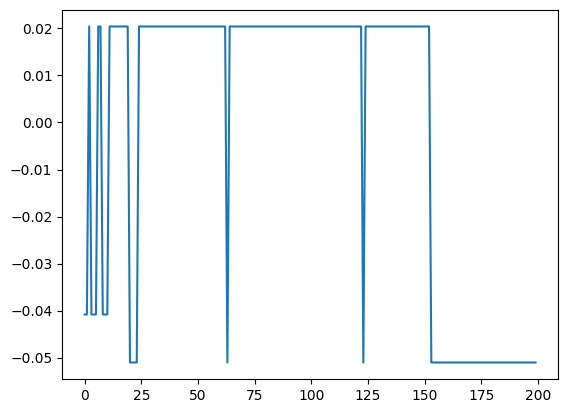

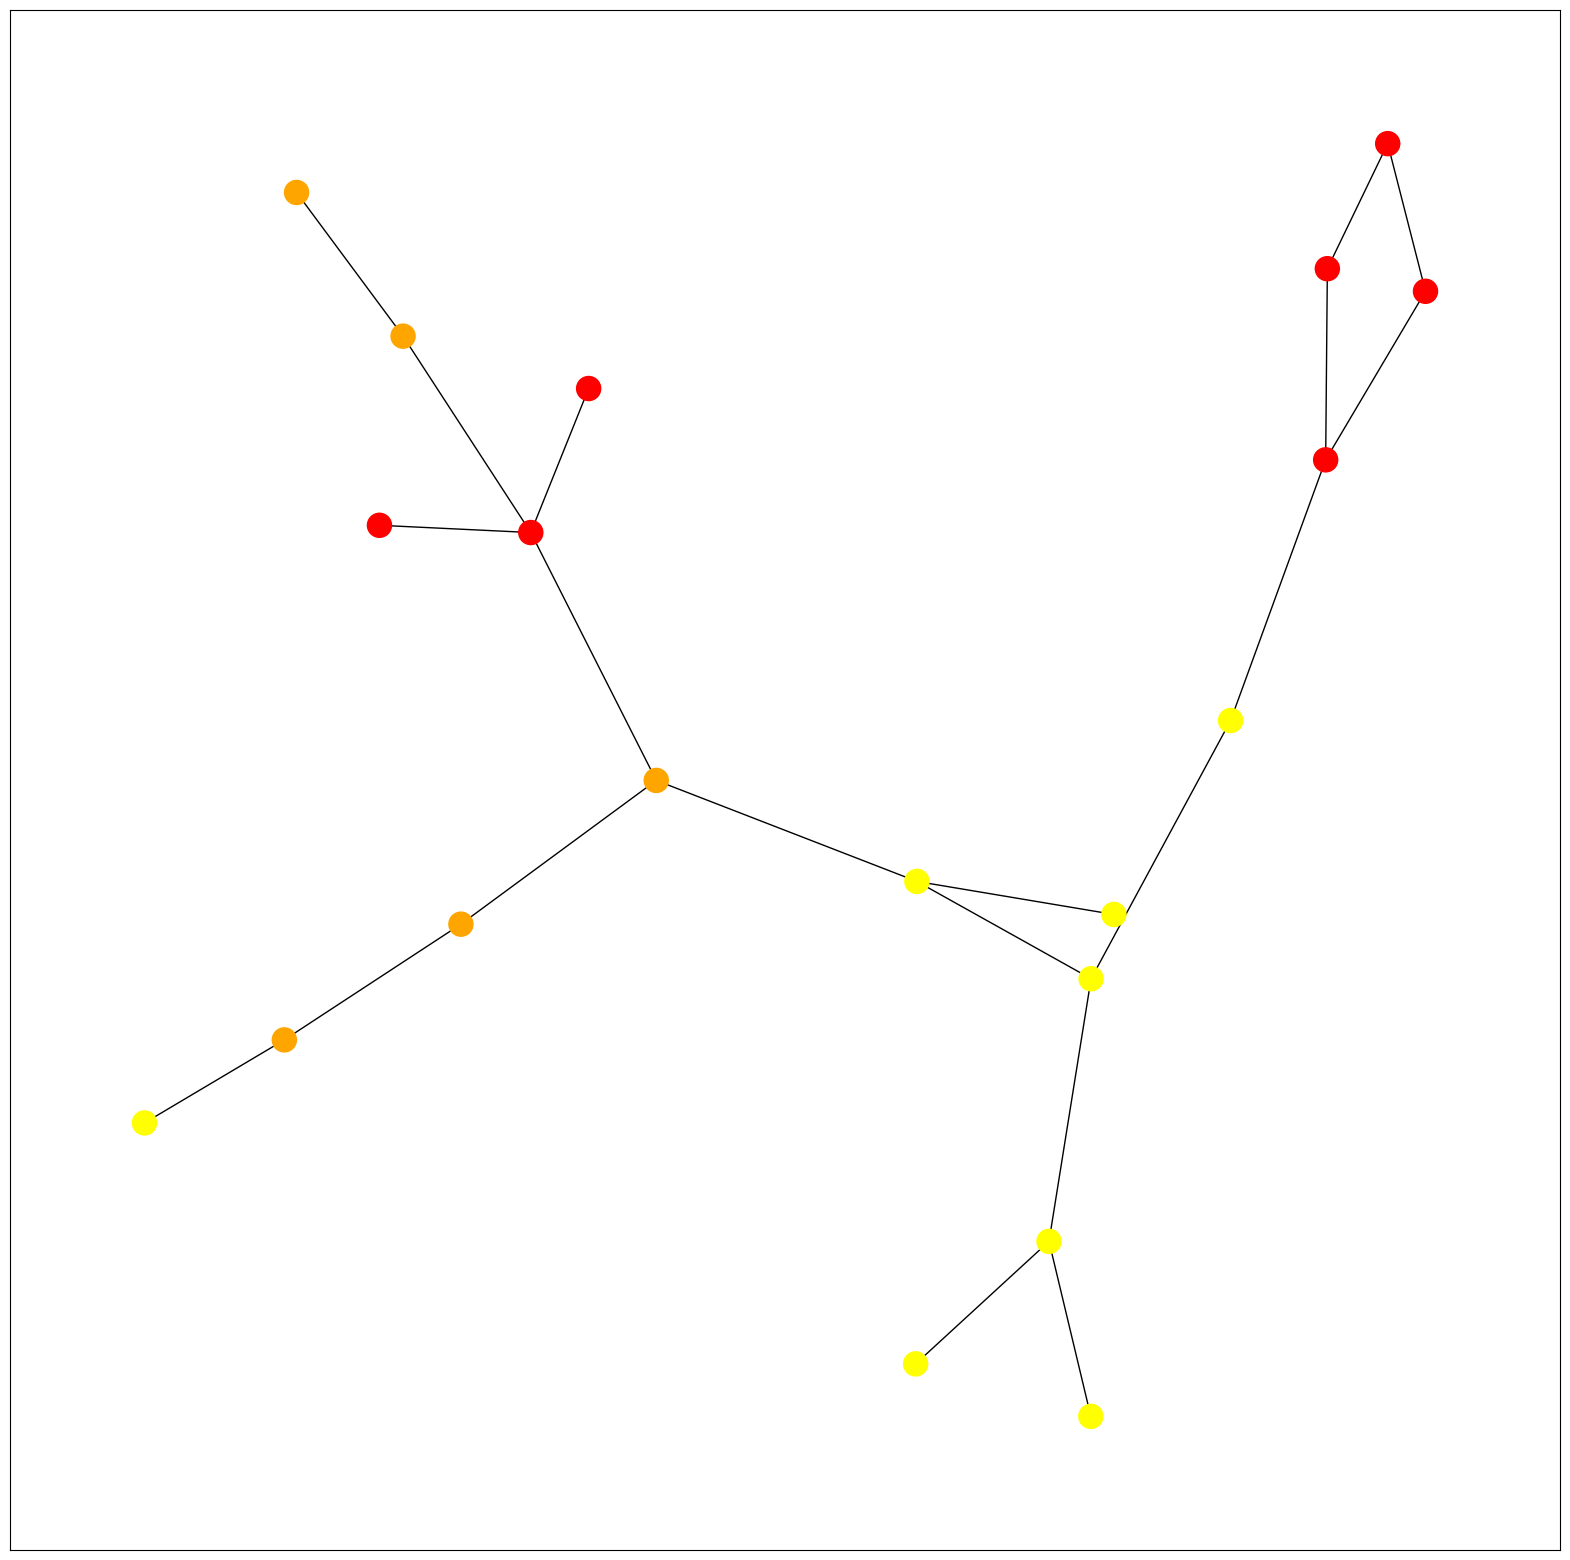

4.871794871794876
32.61309523809524


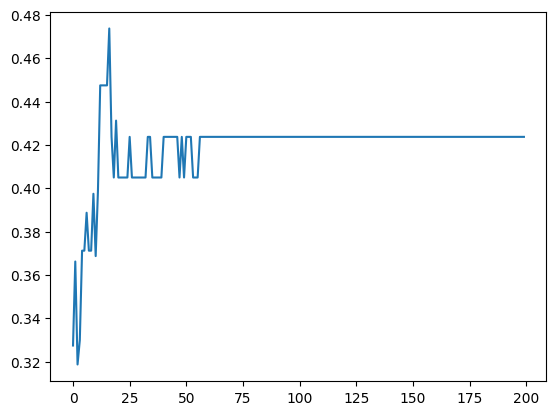

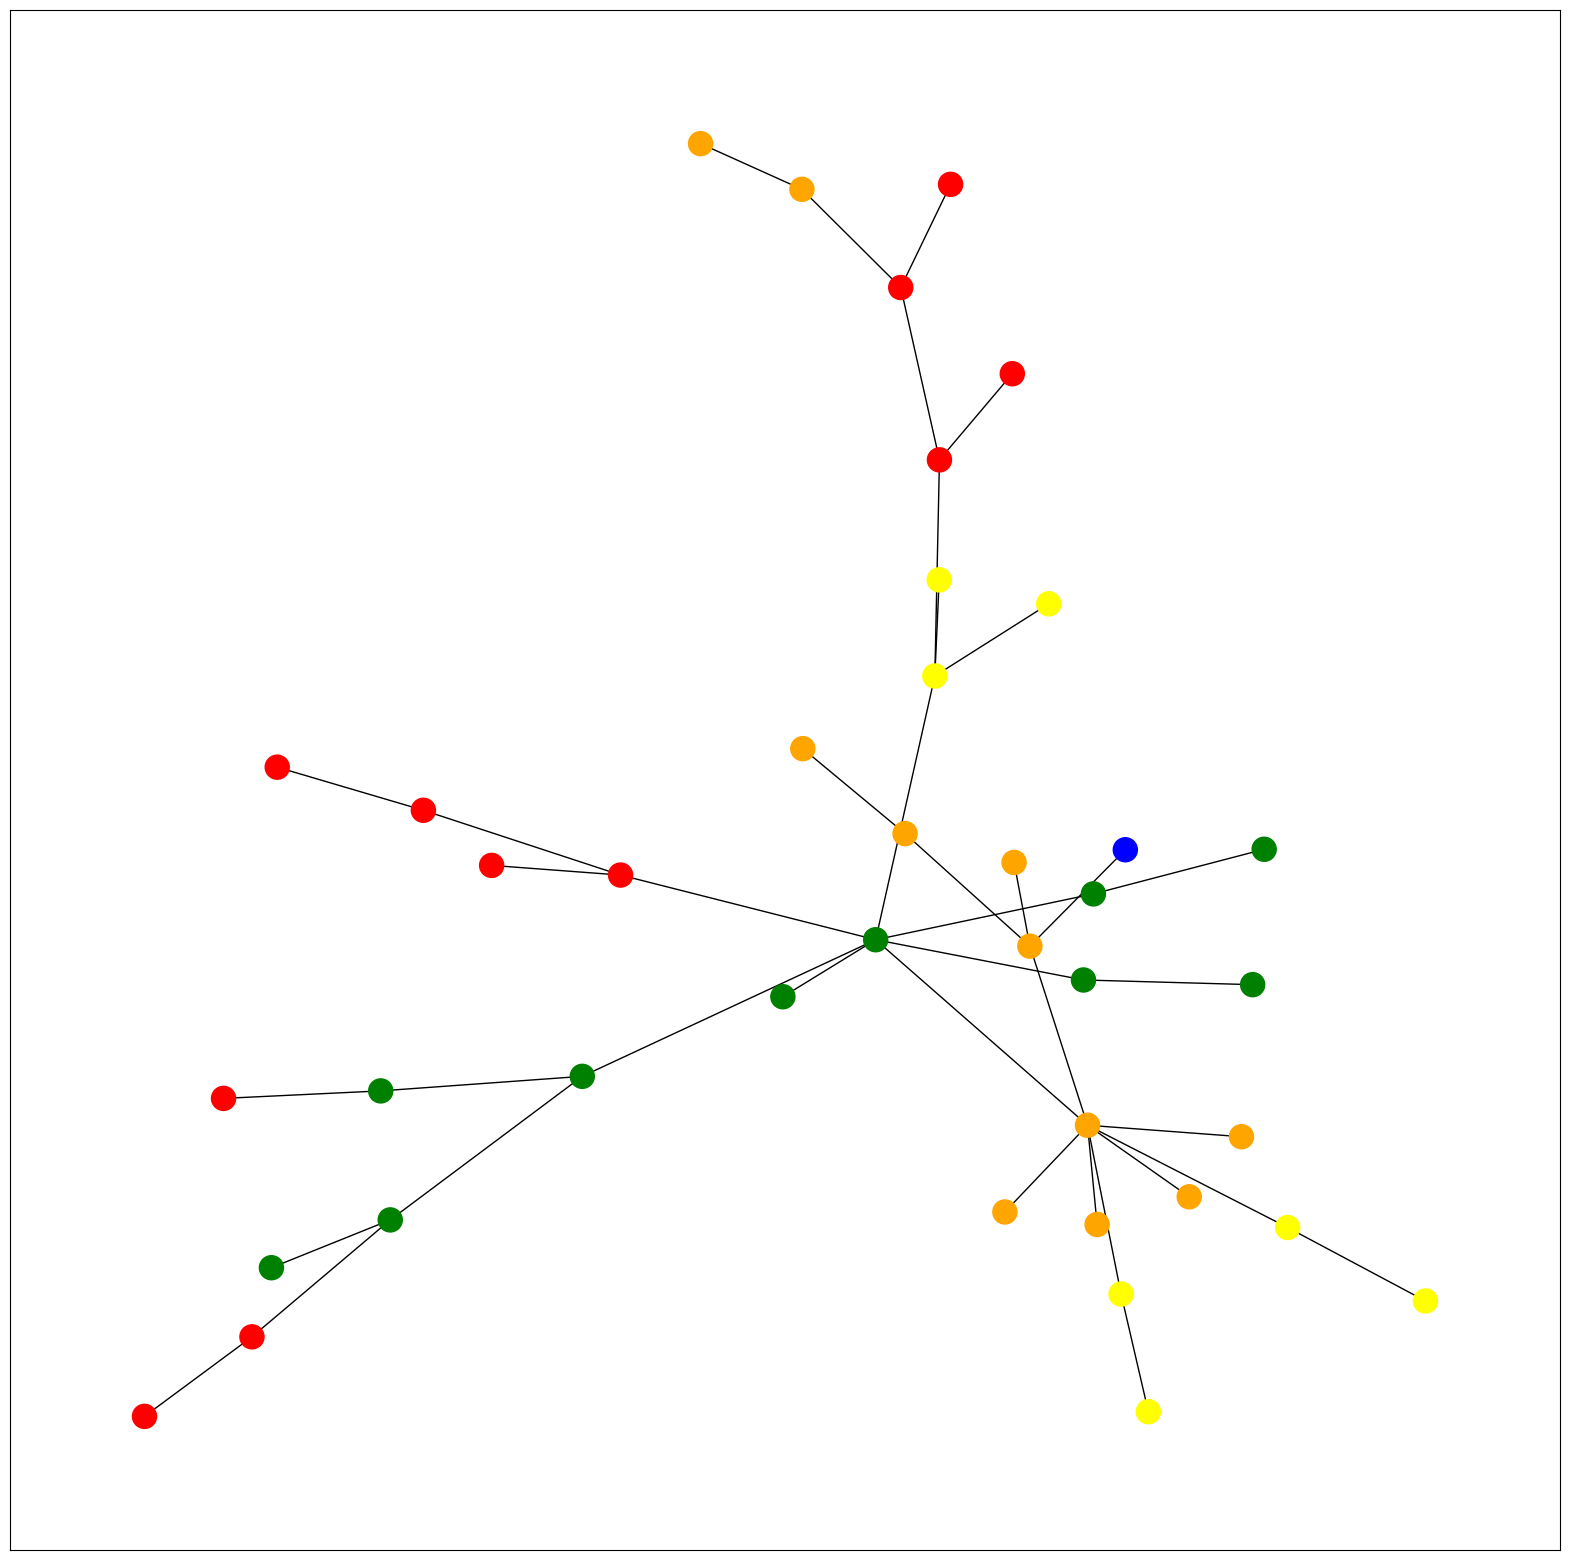

12.387387387387413
76.31190476190477


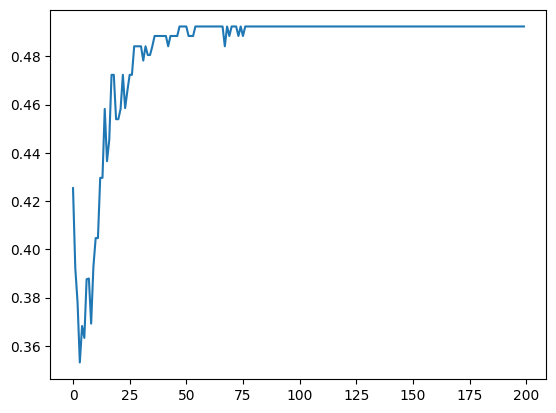

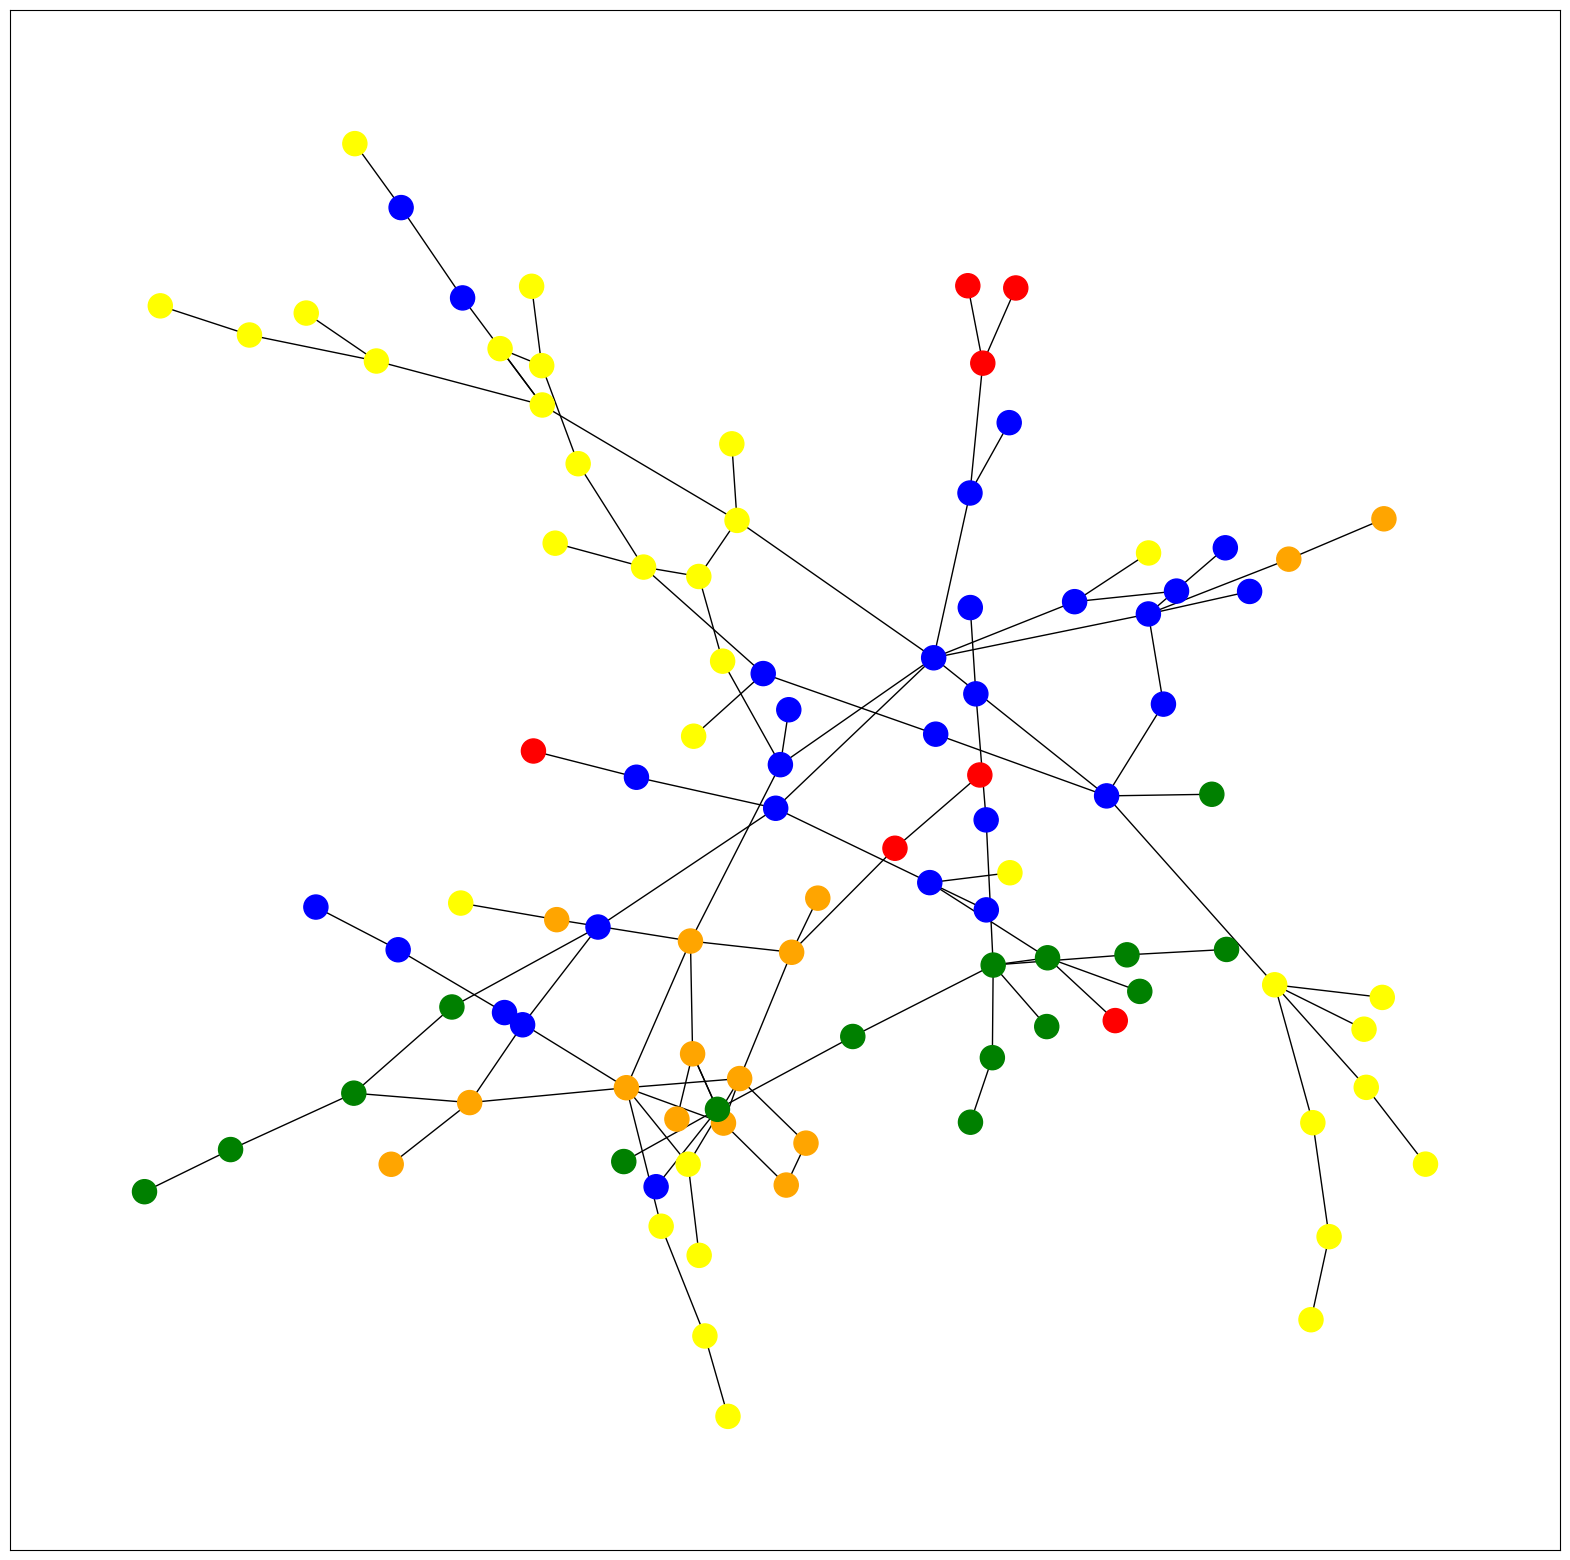

-0.0510204081632653
0.42375000000000007
0.49243918474687576
0.5044233422611847


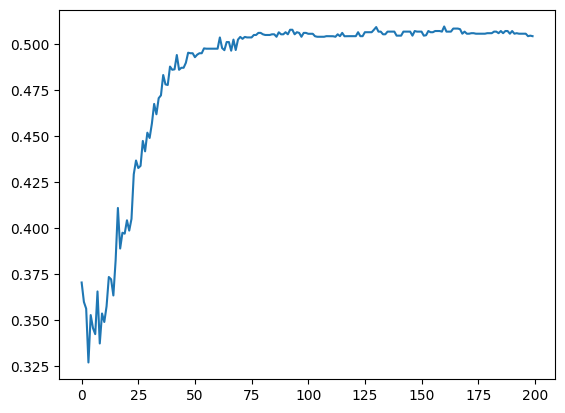

In [112]:
paths = ['data/custom/1s.gml',
         'data/custom/2s.gml',
         'data/custom/1.gml',
         'data/custom/2.gml',]


results = []
for path in paths:
    results.append(do_comm_detection(path, 5, 200))

for result in results:
    print(result.fitness)